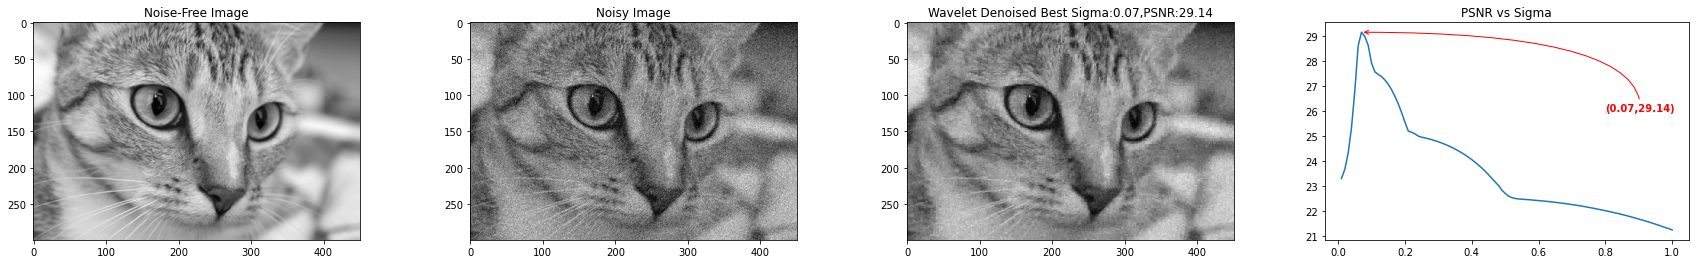

In [1]:
# skimage.restoration 提供了图像去噪的方法，这里我们使用 denoise_wavelet 方法进行小波去噪
# skimage.io 提供了图像的输入输出功能，这里我们使用 io.imread 读取图像
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet
from skimage.io import imread
from skimage import io

from skimage import img_as_float, io
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, denoise_nl_means)
import numpy as np

#读图并添加噪音
img = io.imread("cat.jpg", as_gray=True) #灰度图
#cat_noise=random_noise(img)  #自己添加噪音图

#读取给定噪音图
cat_noise = io.imread('cat_noisy.jpg',as_gray=True)

# 利用小波去噪
# 使用 denoise_wavelet 方法对含有噪音的图像 noisy_img 进行小波去噪
start = np.linspace(0,1,101)
start = start[1:]

X = []
Y = []
#print(start)
for i in start:
    wavelet_img = denoise_wavelet(cat_noise,sigma=i)
    noise_psnr = psnr(img, wavelet_img)
    X.append(i)
    Y.append(noise_psnr)

#转化成np数组
X = np.array(X)
Y = np.array(Y)
#print(Y)

#找出最佳效果(最佳sigma和最佳峰噪比图)
sigma_best = np.argsort(Y)[-1]
wavelet_img_best = denoise_wavelet(cat_noise,sigma=(sigma_best/100))

#将sigma向右向右平移一个单位（为实现图示效果）
sigma_best = sigma_best + 1


# 使用 matplotlib 绘图
# 创建 1 行 4 列的子图，figsize 设置图像的尺寸
fg, ax = plt.subplots(1, 4, figsize=(30, 4))

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Noise-Free Image')  # 设置子图标题


# # 在第二个子图中展示原始的噪音图像
ax[1].imshow(cat_noise, cmap='gray')
ax[1].set_title('Noisy Image')  # 设置子图标题

# # 在第三个子图中展示小波去噪后的结果
ax[2].imshow(wavelet_img_best, cmap='gray')
ax[2].set_title(f'Wavelet Denoised Best Sigma:0.0{sigma_best},PSNR:{round(Y.max(),2)}')  # 设置子图标题

# 画出峰噪比图
ax[3].plot(X,Y)
ax[3].set_title("PSNR vs Sigma")
#print(X.shape,Y.shape)

ax[3].annotate(f'({sigma_best/100},{round(Y.max(),2)})',    #名字
             xy=(sigma_best/100,Y.max()),xytext=(0.8,26),weight='bold',color='r',   #指向點
             
             arrowprops = dict(arrowstyle="->",color='r',   #箭頭格式
                               connectionstyle="angle3")   #箭頭綫改成彎曲
            )

# 显示图像
plt.show()

In [2]:
from skimage import io
import ipywidgets
from skimage import img_as_float
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, denoise_nl_means)
from skimage.metrics import peak_signal_noise_ratio as psnr
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def fft2_denoise(img):
    # TODO 完成fft2去噪算法，实现输入为原图，输出为去噪后的图像
    
    # 1. 载入图像，并将其转换为灰度图像
    im = img 
    h, w = im.shape  # 获取图像的高度和宽度

    # 2. 对图像进行二维傅里叶变换，并进行傅里叶平移操作，将低频成分移到中心
    fCoef = np.fft.fftshift(np.fft.fft2(im))

    # 3. 计算振幅谱，通过对数变换增强对比度，便于观察
    amp_im_fft = np.log(np.abs(fCoef))

    # 4. 创建一个掩模，只保留图像中心区域的低频成分，每个角的面积占总面积的10%
    keep = 0.1  # 每一个角落保留1/10的内容
    mask = np.zeros((h, w))
    h_center = h // 2
    w_center = w // 2
    h_d = int(keep * h)
    w_d = int(keep * w)
    h_min = h_center - h_d
    h_max = h_center + h_d
    w_min = w_center - w_d
    w_max = w_center + w_d
    mask[h_min:h_max, w_min:w_max] = 1  # 将中心区域设置为1，其他区域为0

    # 5. 使用掩模对傅里叶系数进行过滤，去除高频噪声
    fCoef_masked = fCoef * mask

    # 6. 对过滤后的傅里叶系数进行逆平移，并通过逆傅里叶变换还原图像，取实部作为结果
    im_denoised = np.fft.ifft2(np.fft.ifftshift(fCoef_masked)).real
    
    return im_denoised

def optimize_denoise(img_list):
    # 以下虽然用了as_gray=True, 但是对于某些tif仍然无法转化为float
    # 所以仍然要使用img_as_float
    clean_img=img_as_float(io.imread(img_list[0],as_gray=True)) # 干净原图
    noisy_img=img_as_float(io.imread(img_list[1],as_gray=True)) # 有噪音图像
    # TODO 完成此部分代码实现题目要求功能
    
    # 2. 双边滤波去噪
    bilateral_img = denoise_bilateral(noisy_img, multichannel=False) 
    # 3. 全变分去噪
    tv_img = denoise_tv_chambolle(noisy_img)

    # 4. 小波去噪
    wavelet_img = denoise_wavelet(noisy_img)

    # 5. Skimage的非局部均值去噪
    NLM_skimg_denoise_img = denoise_nl_means(noisy_img, patch_size=9, patch_distance=5)
    
    # 1. fft2 去噪
    fft2_img = fft2_denoise(noisy_img)

    
    
    #计算峰噪比
    bilateral_psnr = psnr(clean_img, bilateral_img)
    tv_psnr = psnr(clean_img, tv_img)
    wavelet_psnr = psnr(clean_img, wavelet_img)
    NLM_SK_denoise_psnr = psnr(clean_img, NLM_skimg_denoise_img)
    fft2_psnr = psnr(clean_img, fft2_img)
    print(f'bilateral PSNR:{bilateral_psnr}\ntv PSNR:{tv_psnr}\nwavelet PSNR:{wavelet_psnr}\nNLM PSNR:{NLM_SK_denoise_psnr}\nfft2:{fft2_psnr}')
    
    #创建数据并关联
    X = ['bilateral_img','tv_img','wavelet_img','NLM_skimg_denoise_img','fft2_img']
    Y = [bilateral_psnr,tv_psnr,wavelet_psnr,NLM_SK_denoise_psnr,fft2_psnr]
    LZ = pd.Series(Y,index = X)
    #print(LZ)   #成功
    img_best = LZ.idxmax()
    #print(img_best)
    

    fg,ax = plt.subplots(1,3,figsize=(18,6))
    ax[0].imshow(clean_img,cmap='gray')
    ax[0].set_title('clean_img')
    ax[1].imshow(noisy_img,cmap='gray')
    ax[1].set_title('noisy_img')
    #print(LZ.index)
    
    if img_best == LZ.index[0]:
        ax[2].imshow(bilateral_img,cmap='gray')
        ax[2].set_title(f'bilateral:{LZ[0]}')
    if img_best == LZ.index[1]:
        ax[2].imshow(tv_img,cmap='gray')
        ax[2].set_title(f'tv:{LZ[1]}')
    if img_best == LZ.index[2]:
        ax[2].imshow(wavelet_img,cmap='gray')
        ax[2].set_title(f'wavelet_img:{LZ[2]}')
    if img_best == LZ.index[3]:
        ax[2].imshow(NLM_skimg_denoise_img,cmap='gray')
        ax[2].set_title(f'NLM:{LZ[3]}')
    if img_best == LZ.index[4]:
        ax[2].imshow(fft2_img,cmap='gray')
        ax[2].set_title(f'fft2:{LZ[3]}')

x = ipywidgets.Dropdown(
    options=[('MRI', ("MRI_clean.tif","MRI_noisy.tif")),
             ('cat', ("cat.jpg","cat_noisy.jpg")), 
             ('balloon', ("balloon.jpg","balloon_noisy.jpg")), 
             ('einstein', ("einstein.jpg","einstein_noisy.jpg")),
             ]
    )
ipywidgets.interact(optimize_denoise, img_list=x)

interactive(children=(Dropdown(description='img_list', options=(('MRI', ('MRI_clean.tif', 'MRI_noisy.tif')), (…

<function __main__.optimize_denoise(img_list)>